<a href="https://colab.research.google.com/github/adityasukhwani/DL_Lab/blob/master/AdityaSukhwani_Week7_200968262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import  numpy as np
import  tensorflow as tf
import keras as ks
from sklearn.feature_extraction.text import CountVectorizer
import re
import matplotlib.pyplot as plt

In [ ]:
df_train = pd.read_csv('Train.csv')
df_train = df_train[:20000]
df_test = pd.read_csv('Test.csv')
df_valid = pd.read_csv('Valid.csv')
data = [df_train, df_test, df_valid]

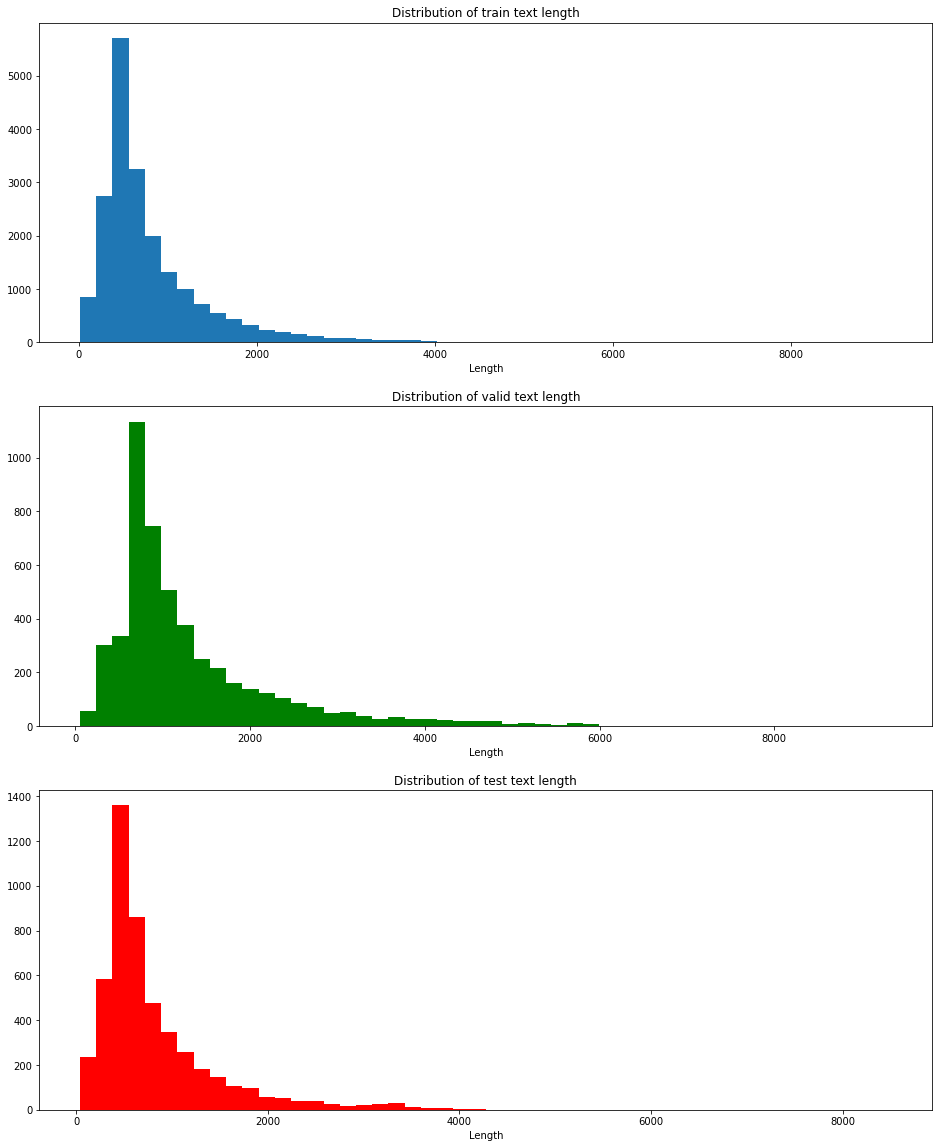

In [ ]:
plt.figure(figsize=(16,20))

plt.subplot(3,1,1)
train_len = [len(l) for l in df_train['text']]
plt.hist(train_len,bins=50)
plt.title('Distribution of train text length')
plt.xlabel('Length')

plt.subplot(3,1,2)
valid_len = [len(l) for l in df_valid['text']]
plt.hist(valid_len,bins=50,color='green')
plt.title('Distribution of valid text length')
plt.xlabel('Length')

plt.subplot(3,1,3)
test_len = [len(l) for l in df_test['text']]
plt.hist(test_len,bins=50,color='red')
plt.title('Distribution of test text length')
plt.xlabel('Length')


plt.show()

In [ ]:
for i in data:
  i['text'] = i['text'].str.lower()

In [ ]:
def sentence_rge(data):
    data=re.sub('<[^>]*>','',data)
    emoji=re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',data)
    data=re.sub('[\W]+',' ',data.lower()) +\
                ' '.join(emoji).replace('-','')
    return data

In [ ]:
df_train['text']=df_train['text'].apply(sentence_rge)
df_test['text']=df_test['text'].apply(sentence_rge)

In [ ]:
from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop=stopwords.words('english')

df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
from collections import Counter
s = ""
for i in df_train['text']:
  s = s + i
split_it = s.split()
Counter = Counter(split_it)
most_occur = Counter.most_common(10)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stop, ngram_range=(2,2))
# matrix of ngrams
ngrams = c_vec.fit_transform(df_train['text'][:2000])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram'})

In [ ]:
y_train = df_train['label']

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
#Lemmatizing the text
from nltk.stem import WordNetLemmatizer
import nltk
def lemmatizer(text):
    lemmatizer = WordNetLemmatizer()
    text= ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text
#Apply function on review column
df_train_lemmatized = df_train
df_train_lemmatized['text'] = df_train_lemmatized['text'].apply(lemmatizer)

In [ ]:
def tokenize(text):
    l = text.split(' ')
    return l

In [ ]:
max_features = 4000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_train_lemmatized['text'].values)
X = tokenizer.texts_to_sequences(df_train_lemmatized['text'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X)
print(X.shape)

(20000, 924)


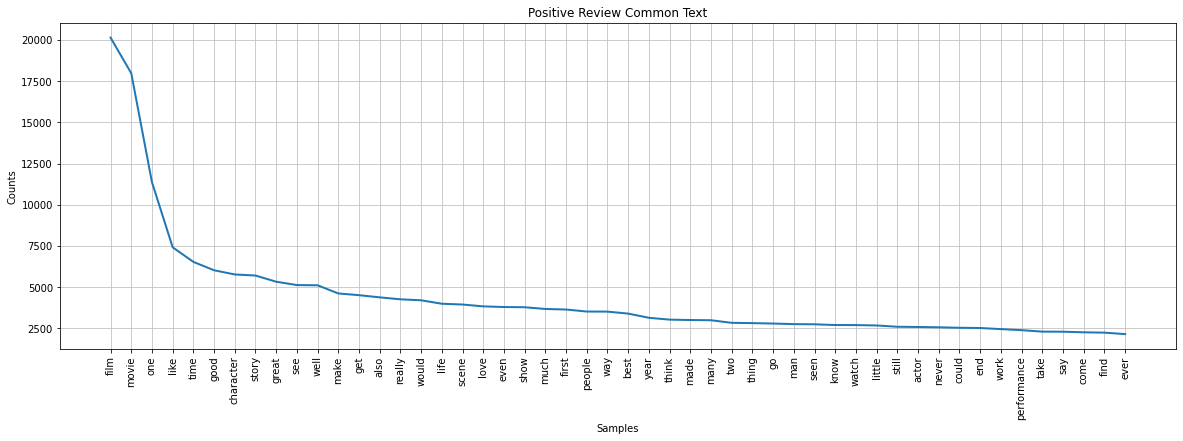

In [ ]:
from nltk.probability import FreqDist
pos_freq = FreqDist(' '.join(df_train_lemmatized[df_train_lemmatized['label'] == 1].text).split(' '))
plt.figure(figsize=(20,6))
pos_freq.plot(50,cumulative=False,title='Positive Review Common Text')
plt.show()

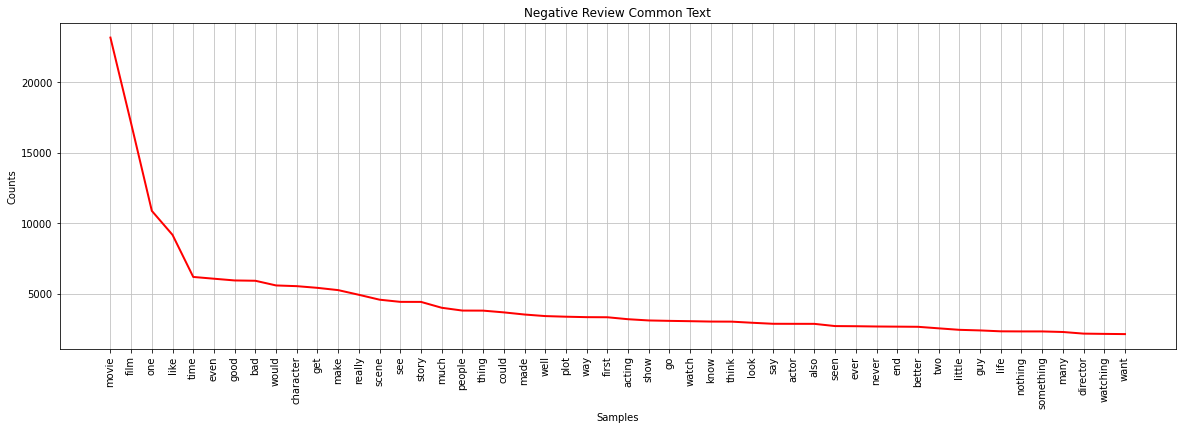

In [ ]:
neg_freq = FreqDist(' '.join(df_train_lemmatized[df_train_lemmatized['label'] == 0].text).split(' '))
plt.figure(figsize=(20,6))
neg_freq.plot(50,cumulative=False,title='Negative Review Common Text',color='red')
plt.show()

In [ ]:
print(most_occur)

[('movie', 33445), ('film', 30784), ('one', 20736), ('like', 15947), ('good', 11737), ('time', 9898), ('even', 9800), ('would', 9714), ('story', 9163), ('really', 8921)]


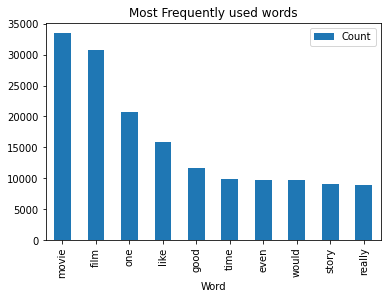

In [ ]:
df_most = pd.DataFrame(most_occur, columns = ['Word', 'Count'])
df_most.plot.bar(x='Word',y='Count')
plt.title('Most Frequently used words')
plt.show()

In [ ]:
df_ngram.head(10)

,frequency,bigram
0,100,ever seen
1,87,special effects
2,82,low budget
3,78,even though
4,70,one best
5,68,see movie
6,66,waste time
7,64,watch movie
8,63,first time
9,62,year old


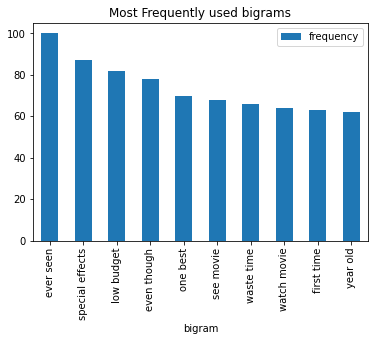

In [ ]:
df_most2 = pd.DataFrame(df_ngram.head(10), columns = ['frequency', 'bigram'])
df_most2.plot.bar(x='bigram',y='frequency')
plt.title('Most Frequently used bigrams')
plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from keras.layers import Embedding
### LSTM
model = Sequential()
model.add(Embedding(input_dim = max_features, output_dim = 256, input_length=X.shape[1]))
# model.add(SpatialDropout1D(0.7))
# First layer
model.add(LSTM(units=50, return_sequences= True, input_shape=(X.shape[1],1)))
# model.add(LSTM(units=50, return_sequences= True))
model.add(Dropout(0.2))
# Second Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Third Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Fourth Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Fifth Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Sixth Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Seventh Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Eight Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Ninth Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Tenth Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Eleventh Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Twelth Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Thirteenth Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Fourteenth Layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
#Fifteenth Layer
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
#Output Layer
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 924, 256)          1024000   
                                                                 
 lstm (LSTM)                 (None, 924, 50)           61400     
                                                                 
 dropout (Dropout)           (None, 924, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 924, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 924, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 924, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 924, 50)           0

In [ ]:
h = model.fit(X, y_train, epochs = 10, batch_size=32, validation_split = 0.15)

Epoch 1/10
532/532 [==============================] - 239s 407ms/step - loss: 0.6831 - accuracy: 0.5315 - val_loss: 0.6035 - val_accuracy: 0.6897
Epoch 2/10
532/532 [==============================] - 212s 398ms/step - loss: 0.4482 - accuracy: 0.8055 - val_loss: 0.3771 - val_accuracy: 0.8487
Epoch 3/10
532/532 [==============================] - 212s 398ms/step - loss: 0.2966 - accuracy: 0.8862 - val_loss: 0.3889 - val_accuracy: 0.8510
Epoch 4/10
532/532 [==============================] - 211s 398ms/step - loss: 0.2317 - accuracy: 0.9161 - val_loss: 0.3493 - val_accuracy: 0.8617
Epoch 5/10
532/532 [==============================] - 212s 399ms/step - loss: 0.1745 - accuracy: 0.9392 - val_loss: 0.4118 - val_accuracy: 0.8613
Epoch 6/10
532/532 [==============================] - 212s 398ms/step - loss: 0.1311 - accuracy: 0.9568 - val_loss: 0.3810 - val_accuracy: 0.8717
Epoch 7/10
532/532 [==============================] - 212s 398ms/step - loss: 0.1075 - accuracy: 0.9678 - val_loss: 0.3772 -

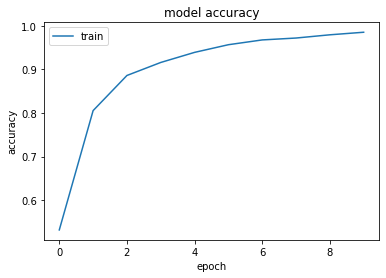

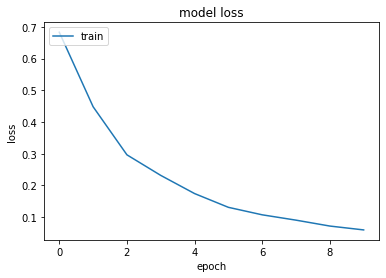

In [ ]:
plt.plot(h.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(h.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
lstm_out = 196

model1 = Sequential()
model1.add(Embedding(input_dim = max_features, output_dim = 256, input_length=X.shape[1]))

model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05, return_sequences = True)))
model1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_out, dropout=0.05)))

#Output Layer
model1.add(tf.keras.layers.Dense(2, activation = 'softmax'))

model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
h2 = model1.fit(X, y_train, epochs = 10, batch_size=32, validation_split = 0.15)

Epoch 1/10
532/532 [==============================] - 670s 1s/step - loss: 0.6871 - accuracy: 0.5206 - val_loss: 0.6932 - val_accuracy: 0.4960
Epoch 2/10
532/532 [==============================] - 640s 1s/step - loss: 0.6937 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5040
Epoch 3/10
532/532 [==============================] - 640s 1s/step - loss: 0.6933 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4960
Epoch 4/10
532/532 [==============================] - 640s 1s/step - loss: 0.6934 - accuracy: 0.4959 - val_loss: 0.6932 - val_accuracy: 0.4960
Epoch 5/10
 90/532 [====>.........................] - ETA: 8:20 - loss: 0.6931 - accuracy: 0.5128

KeyboardInterrupt: ignored

In [ ]:
plt.plot(h2.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(h2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()